# Classification models to predict vehicle loan outcomes

<br>
 

### In this notebook I will use three classification models to predict loan outcomes:
1. K Nearest Neigbours
2. Decision Tree
3. Logistic Regression

___
**1.** In the first section I will use the previously prepared dataset with the selected featureset and evaluate the models using:
+ jaccard score
+ f1 score
+ recall score

*(I will also include full classification report for each model)*


**2.** In the second section I will use **SMOTE** to account for the skewed distribution of the classes and re-run the models.


**3.** In the last section I will resample the dataset to an equal distribution between the classes and run the models again.

___

### Table of contents:

1. [Preparing the data](#Preprocessing-and-normalizing-the-data)
2. [Initial run](#K-nearest-neighbor)
    + [K nearest neighbors](#K-nearest-neighbor)
    + [Decision Tree](#Decision-Tree)
    + [Logistic Regression](#Logistic-Regression)
    

3. [Evaluation of the initial run](#Evaluation-of-all-three-models)
4. [Findings](#Findings)

5. [Second run with SMOTE](#K-nearest-neighbors-2nd-round)
    + [K nearest neighbors](#K-nearest-neighbors-2nd-round)
    + [Decision Tree](#Decision-Tree-2nd-round)
    + [Logistic Regression](#Logistic-Regression-2nd-round)
    
    
6. [Evaluation of second run](#Results)
7. [Findings after second run](#Findings-2nd-run)

8. [Third run with equal distribution](#K-nearest-neighbors-3rd-round)
    + [K nearest neighbors](#K-nearest-neighbors-3rd-round)
    + [Decision Tree](#Decision-Tree-3rd-round)
    + [Logistic Regression](#Logistic-Regression-3rd-round)
    
    
9. [Evaluation after third run](#Results-after-3rd-run)
10. [Conclusion](#Conclusion)
 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import jaccard_score, confusion_matrix, classification_report, f1_score, accuracy_score, recall_score

In [2]:
df_train = pd.read_csv('train_new.csv', index_col=0)
df_test = pd.read_csv('test_new.csv', index_col=0)

In [3]:
df_train.shape

(233154, 33)

<br>

Due to the size of the data and the lack of computing power on my machine I will take a random sample of 10000 records of this dataset.


This will help reduce the processing time when running the models.

In [4]:
train = df_train.sample(10000)

<br>
<br>
Let's compare the distribution of LOAN_DEFAULT values in the original vs the random sample dataset

In [80]:
print(f'Random set: \n {train.LOAN_DEFAULT.value_counts(normalize=True)}, \n Original set: \n {df_train.LOAN_DEFAULT.value_counts(normalize=True)}')

Random set: 
 0    0.7843
1    0.2157
Name: LOAN_DEFAULT, dtype: float64, 
 Original set: 
 0    0.782929
1    0.217071
Name: LOAN_DEFAULT, dtype: float64


<br>


#### They are fairly close with a similar distribution in values of LOAN_DEFAULT, so the random set is a true representation of the large, original set.

___

# Preprocessing and normalizing the data

<br>

In this section I will:
+ separate the class variable from the rest of the dataset
+ separate binary values from continuous ones
+ normalize continuous values
+ split the data to train and test set

In [81]:
# Factory function to prepare the data

def prepare_data(df):
    # Separating the class variables from the rest of the dataset
    X = df.drop(['LOAN_DEFAULT'], axis=1)
    y = df['LOAN_DEFAULT'].values
    # Separating the binary values from continuous columns
    binaries = X[['PAN_FLAG','VOTERID_FLAG','AADHAR_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG', 'Salaried', 'Self employed']]
    continuous = X.drop(binaries, axis=1)
    continuous = StandardScaler().fit(continuous).transform(continuous.astype('float'))
    X = np.concatenate((binaries.values, continuous), axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)
    
    
    return X_train, X_test, y_train, y_test

<br>

*Although the original data was split to train and test sets, I discovered that the test data had not been labeled, which makes it difficult to measure the accuracy of the models.*

*To resolve, this I included a train test split function  to split the train dataset with a 0.3 test size so that I can measure the accuracy.*

*The dataset called 'test' will be used for the actual prediction once the models have been built.*

In [82]:
X_train, X_test, y_train, y_test = prepare_data(train)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7000, 32) (3000, 32) (7000,) (3000,)


### Factory functions for plotting

In [83]:
# Factory function for confusion matrices
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [84]:
# Factory function to create final result plot
def plot_results(results_df):
    fig = plt.figure(figsize=(18,10))
    ax1 = fig.add_subplot(1,3,1)
    ax1 = results_df.loc['K nearest neighbours'].plot(kind='bar', width=0.8, ax=ax1)
    for p in ax1.patches:
        ax1.annotate(format(round(p.get_height(), 2)),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 9),
                       textcoords='offset points')
    ax1.set_xticklabels(results_df.loc['K nearest neighbours'].index, rotation=0)
    ax1.set_title('K nearest neighbours', size=16)
    ax2 = fig.add_subplot(1,3,2)
    ax2 = results_df.loc['Decision Tree'].plot(kind='bar', width=0.8, ax=ax2)
    for p in ax2.patches:
        ax2.annotate(format(round(p.get_height(), 2)),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 9),
                       textcoords='offset points')
    ax2.set_xticklabels(results_df.loc['Decision Tree'].index, rotation=0)
    ax2.set_title('Decision Tree', size=16)
    ax3 = fig.add_subplot(1,3,3)
    ax3 = results_df.loc['Logistic Regression'].plot(kind='bar', width=0.8, ax=ax3)
    for p in ax3.patches:
        ax3.annotate(format(round(p.get_height(), 2)),
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center',
                       xytext=(0, 9),
                       textcoords='offset points')
    ax3.set_xticklabels(results_df.loc['Decision Tree'].index, rotation=0)
    ax3.set_title('Logistics Regression', size=16)
    fig.suptitle('Accuracy scores of all 3 models per class and average', size=20)

In [126]:
# Factory function for creating results summary
def results_frame(KNNpred,TREEpred,LRpred):
    results= {
        'K nearest neighbours': {
            'Average': {
                'Jaccard score': jaccard_score(y_test, KNNpred, average='weighted'), 'Recall score': recall_score(y_test, KNNpred, average='weighted'), 'F1 score': f1_score(y_test, KNNpred, average='weighted')
            },
            'Paid class': {
                'Jaccard score': jaccard_score(y_test, KNNpred, pos_label=0), 'Recall score': recall_score(y_test, KNNpred, pos_label=0), 'F1 score': f1_score(y_test, KNNpred, pos_label=0)
            },

            'Defaulted class': {
                'Jaccard score': jaccard_score(y_test, KNNpred, pos_label=1), 'Recall score': recall_score(y_test, KNNpred, pos_label=1), 'F1 score': f1_score(y_test, KNNpred, pos_label=1)
            },
        },
        'Decision Tree': {
            'Average': {
                'Jaccard score': jaccard_score(y_test, TREEpred, average='weighted'), 'Recall score': recall_score(y_test, TREEpred, average='weighted'), 'F1 score': f1_score(y_test, TREEpred, average='weighted')
            },
            'Paid class': {
                'Jaccard score': jaccard_score(y_test, TREEpred, pos_label=0), 'Recall score': recall_score(y_test, TREEpred, pos_label=0), 'F1 score': f1_score(y_test, TREEpred, pos_label=0)
            },

            'Defaulted class': {
                'Jaccard score': jaccard_score(y_test, TREEpred, pos_label=1), 'Recall score': recall_score(y_test, TREEpred, pos_label=1), 'F1 score': f1_score(y_test, TREEpred, pos_label=1)
            },
        },
        'Logistic Regression': {
            'Average': {
                'Jaccard score': jaccard_score(y_test, LRpred, average='weighted'), 'Recall score': recall_score(y_test, LRpred, average='weighted'), 'F1 score': f1_score(y_test, LRpred, average='weighted')
            },
            'Paid class': {
                'Jaccard score': jaccard_score(y_test, LRpred, pos_label=0), 'Recall score': recall_score(y_test, LRpred, pos_label=0), 'F1 score': f1_score(y_test, LRpred, pos_label=0)
            },

            'Defaulted class': {
                'Jaccard score': jaccard_score(y_test, LRpred, pos_label=1), 'Recall score': recall_score(y_test, LRpred, pos_label=1), 'F1 score': f1_score(y_test, LRpred, pos_label=1)
            },
        }
    }
    
    results_df = pd.DataFrame.from_dict({(i,j): results[i][j] 
                           for i in results.keys() 
                           for j in results[i].keys()},
                       orient='index')
    
    return results_df



# K-nearest neighbor


___
First, I will find the best value for k

In [86]:
from sklearn.neighbors import KNeighborsClassifier

In [87]:
Ks = np.arange(1,20, 1);
scores = []
for k in Ks:
    knn  = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    yhat = knn.predict(X_test)
    scores.append(accuracy_score(y_test, yhat))

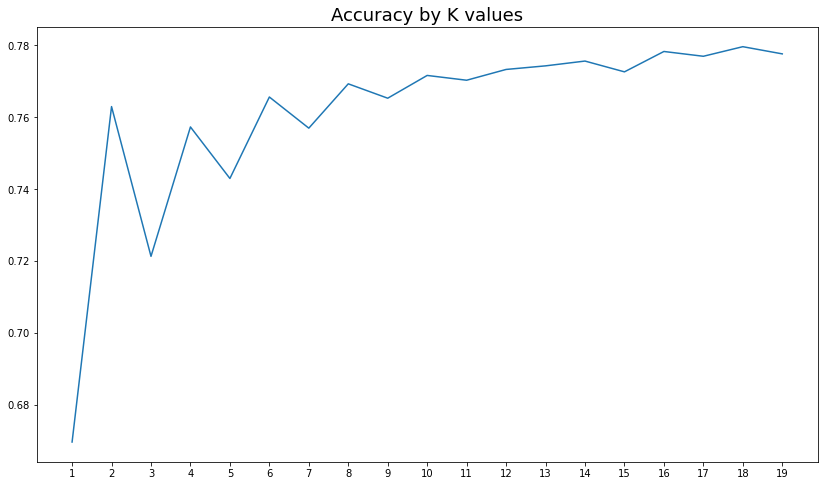

In [88]:
plt.figure(figsize=(14,8))
plt.plot(Ks, scores)
plt.xticks(Ks)
plt.title('Accuracy by K values', size=18)
plt.show()

Based on the chart the k value with the highest accuracy on this dataset is 18.

I will now run the model with this k value and save the predictions

In [89]:
knn  = KNeighborsClassifier(n_neighbors=18).fit(X_train,y_train)
KNNpred = knn.predict(X_test)
KNNpred

array([0, 0, 0, ..., 0, 0, 0])

In [90]:
knn.score(X_train, y_train)

0.7894285714285715

Normalized confusion matrix
[[0.99360341 0.00639659]
 [0.98625954 0.01374046]]


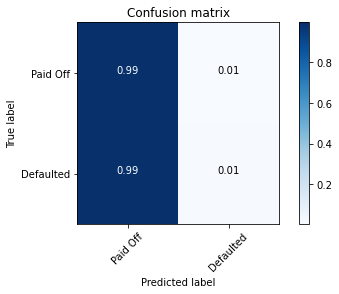

In [91]:
cm = confusion_matrix(y_test, KNNpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= True,  title='Confusion matrix')

In [92]:
class_report_KNN = classification_report(y_test, KNNpred)
print(class_report_KNN)

              precision    recall  f1-score   support

           0       0.78      0.99      0.88      2345
           1       0.38      0.01      0.03       655

    accuracy                           0.78      3000
   macro avg       0.58      0.50      0.45      3000
weighted avg       0.69      0.78      0.69      3000



---
# Decision Tree

<br>

Let's first see what's the best value for max_depth

In [6]:
from sklearn.tree import DecisionTreeClassifier

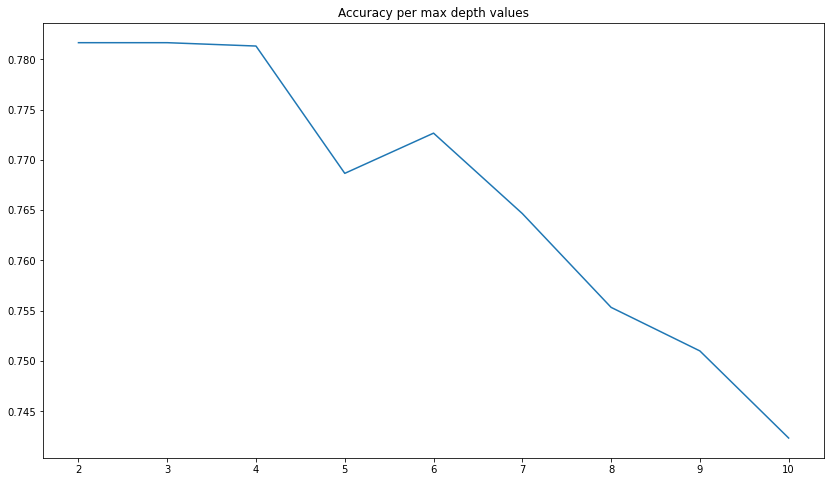

In [94]:
values = range(2,11)
scores = []
for value in values:
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=value).fit(X_train, y_train)
    yhat = tree.predict(X_test)
    scores.append(accuracy_score(y_test, yhat))
plt.figure(figsize=(14,8))
plt.plot(values, scores)
plt.title('Accuracy per max depth values')
plt.show()

A value of 2 seems to produce the best result

In [95]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=2).fit(X_train, y_train)

In [96]:
tree.score(X_train,y_train)

0.7854285714285715

In [97]:
TREEpred = tree.predict(X_test)

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


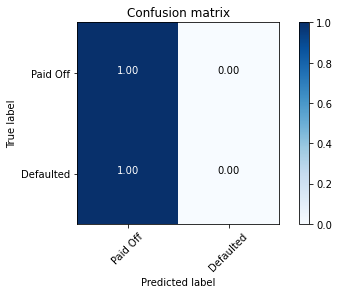

In [98]:
cm = confusion_matrix(y_test, TREEpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= True,  title='Confusion matrix')

In [99]:
class_report_TREE = classification_report(y_test, TREEpred)
print(class_report_TREE)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2345
           1       0.00      0.00      0.00       655

    accuracy                           0.78      3000
   macro avg       0.39      0.50      0.44      3000
weighted avg       0.61      0.78      0.69      3000



/Users/robertczikkel/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertczikkel/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/robertczikkel/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---


# Logistic Regression


<br>


I will use the liblinear solver with a regularization value of 0.01

In [100]:
from sklearn.linear_model import LogisticRegression

In [101]:
lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train.astype('int'))

In [102]:
LRpred = lr.predict(X_test)
LRpred[:5]

array([0, 0, 0, 0, 0])

In [103]:
class_report_LR = classification_report(y_test, LRpred)
print(class_report_LR)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      2345
           1       0.29      0.00      0.01       655

    accuracy                           0.78      3000
   macro avg       0.53      0.50      0.44      3000
weighted avg       0.67      0.78      0.69      3000



Normalized confusion matrix
[[0.9978678  0.0021322 ]
 [0.99694656 0.00305344]]


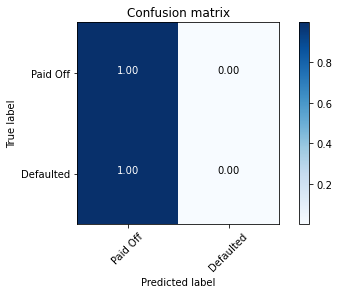

In [104]:
cm = confusion_matrix(y_test, LRpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= True,  title='Confusion matrix')

---

# Evaluation of all three models

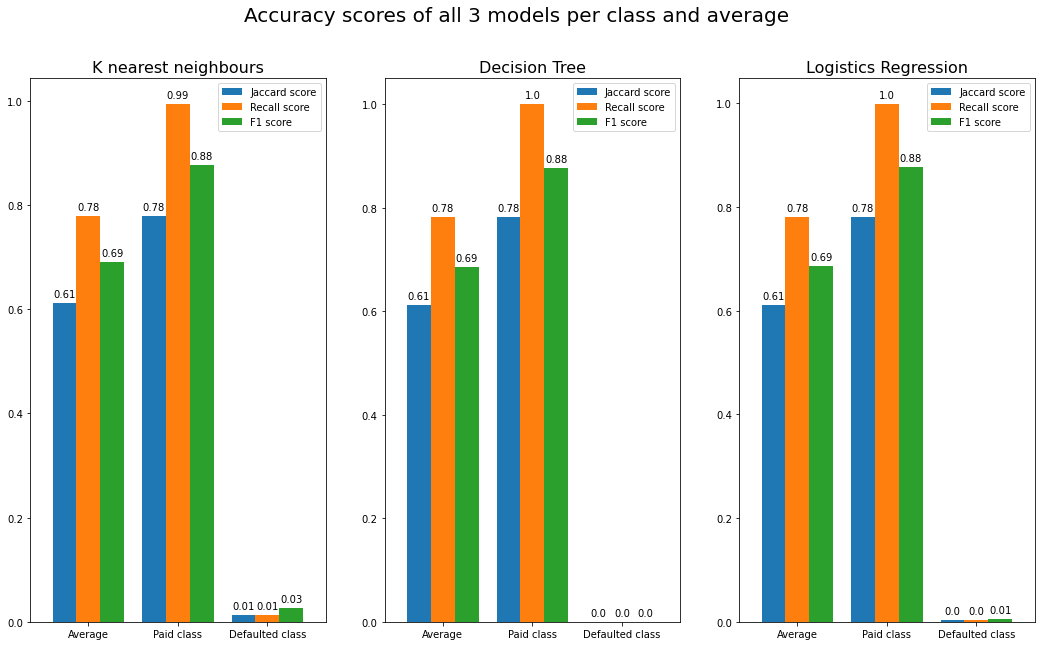

In [105]:
results_df = results_frame(KNNpred,TREEpred,LRpred)
plot_results(results_df)

In [106]:
print(
class_report_KNN,
class_report_TREE,
class_report_LR,
)

              precision    recall  f1-score   support

           0       0.78      0.99      0.88      2345
           1       0.38      0.01      0.03       655

    accuracy                           0.78      3000
   macro avg       0.58      0.50      0.45      3000
weighted avg       0.69      0.78      0.69      3000
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      2345
           1       0.00      0.00      0.00       655

    accuracy                           0.78      3000
   macro avg       0.39      0.50      0.44      3000
weighted avg       0.61      0.78      0.69      3000
               precision    recall  f1-score   support

           0       0.78      1.00      0.88      2345
           1       0.29      0.00      0.01       655

    accuracy                           0.78      3000
   macro avg       0.53      0.50      0.44      3000
weighted avg       0.67      0.78      0.69      3000



# Findings

---
None of the models performs well in predicting loan defaults:
+ Apart from K nearest neighbors all models had zero correct predicition of defaults 
+ K nearest neighbours performed the best with a mere 1% correct predictions on defaults, which is still very low

#### This issue here is the so called Imbalanced Classification problem that results from the skewed distribution of the class variable.
* 78.29% of the data is classified as 'paid', and only 21.71% is labelled as 'defaulted'.

The models are therefore treating the majority class as a default class and mislabels the test set as the minority class is seen as anomaly or abnormal case

<br>

**Solutions to overcome this problem could be:**
+ increasing the size of the dataset
+ oversampling with SMOTE
+ resampling to equal distribution of the classes

---
### I will now increase the sample size and use SMOTE to oversample the Defaulted class

In [107]:
train = df_train.sample(50000)

In [108]:
X_train, X_test, y_train, y_test = prepare_data(train)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35000, 32) (15000, 32) (35000,) (15000,)


In [109]:
from imblearn.over_sampling import SMOTE

In [110]:
sm = SMOTE(random_state=27)

X_train, y_train = sm.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)

(54606, 32) (54606,)


# K nearest neighbors 2nd round

In [111]:
Ks = np.arange(1,10, 1);
scores = []
for k in Ks:
    knn  = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    yhat = knn.predict(X_test)
    scores.append(accuracy_score(y_test, yhat))

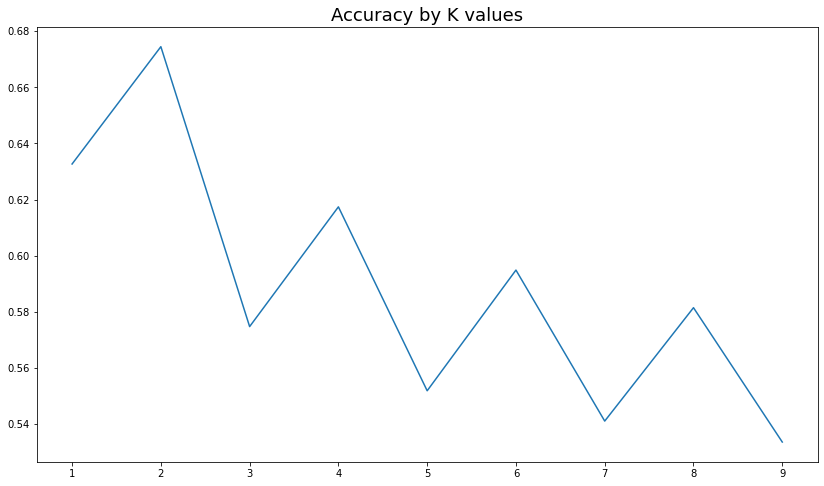

In [112]:
plt.figure(figsize=(14,8))
plt.plot(Ks, scores)
plt.xticks(Ks)
plt.title('Accuracy by K values', size=18)
plt.show()

In [113]:
knn  = KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
KNNpred = knn.predict(X_test)

In [115]:
class_report_KNN_new = classification_report(y_test, KNNpred)
print(class_report_KNN_new)

              precision    recall  f1-score   support

           0       0.80      0.78      0.79     11807
           1       0.26      0.28      0.27      3193

    accuracy                           0.67     15000
   macro avg       0.53      0.53      0.53     15000
weighted avg       0.68      0.67      0.68     15000



Normalized confusion matrix
[[0.78106208 0.21893792]
 [0.71969934 0.28030066]]


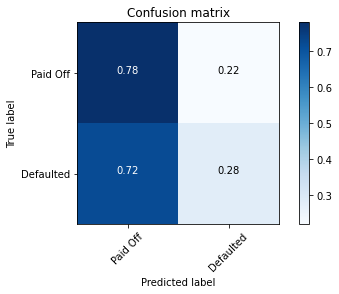

In [116]:
cm = confusion_matrix(y_test, KNNpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= True,  title='Confusion matrix')

The overall scores seem to be lower but the model now predicts defaults with a 28% accuracy

<br>

I will now go on to re-run the other two models

# Decision Tree 2nd round

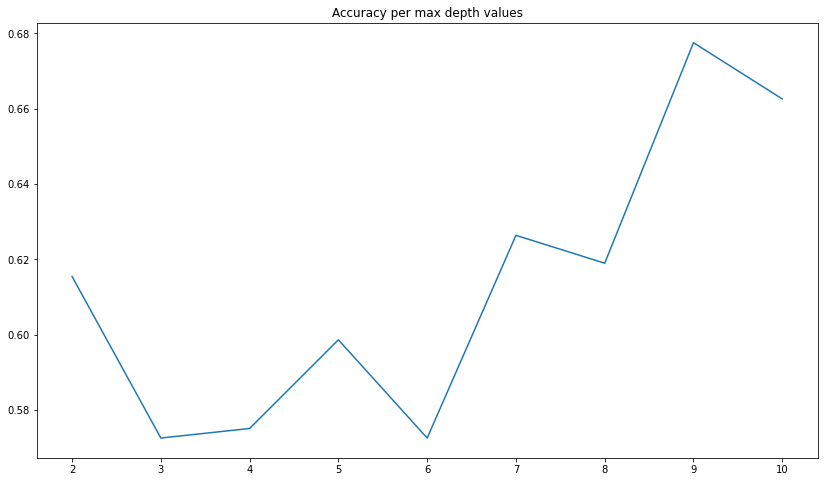

In [117]:
values = range(2,11)
scores = []
for value in values:
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=value).fit(X_train, y_train)
    yhat = tree.predict(X_test)
    scores.append(accuracy_score(y_test, yhat))
plt.figure(figsize=(14,8))
plt.plot(values, scores)
plt.title('Accuracy per max depth values')
plt.show()

A max_depth value of 9 produces the highest score, let's re-run the model with it



<br>

In [118]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=9).fit(X_train, y_train)
TREEpred = tree.predict(X_test)

In [119]:
class_report_TREE_new = classification_report(y_test, TREEpred)
print(class_report_TREE_new)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     11807
           1       0.27      0.31      0.29      3193

    accuracy                           0.68     15000
   macro avg       0.54      0.54      0.54     15000
weighted avg       0.69      0.68      0.68     15000



Normalized confusion matrix
[[0.77674261 0.22325739]
 [0.68932039 0.31067961]]


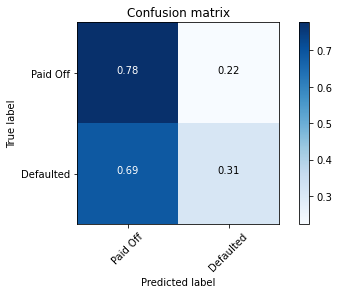

In [120]:
cm = confusion_matrix(y_test, TREEpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= True,  title='Confusion matrix')

With a resampled and adjusted dataset Desicion Tree has produced an accuracy in predicting loan defaults of 31%

# Logistic Regression 2nd round

In [121]:
lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train.astype('int'))

In [122]:
LRpred = lr.predict(X_test)

In [123]:
class_report_LR_new = classification_report(y_test, LRpred)
print(class_report_LR_new)

              precision    recall  f1-score   support

           0       0.85      0.54      0.66     11807
           1       0.28      0.66      0.39      3193

    accuracy                           0.56     15000
   macro avg       0.57      0.60      0.53     15000
weighted avg       0.73      0.56      0.60     15000



Normalized confusion matrix
[[0.53832472 0.46167528]
 [0.34105857 0.65894143]]


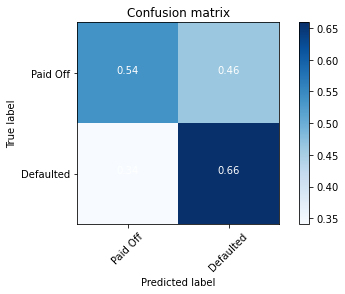

In [124]:
cm = confusion_matrix(y_test, LRpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= True,  title='Confusion matrix')

While the accuracy of predicting loan defaults has increased to 66% with Logistic Regression, it happened at the cost of the accuracy in predicting the other class, which is not ideal given that the model is predicting good applicants only at a 50% rate.

# Results

In [127]:
results_df = results_frame(KNNpred,TREEpred,LRpred)

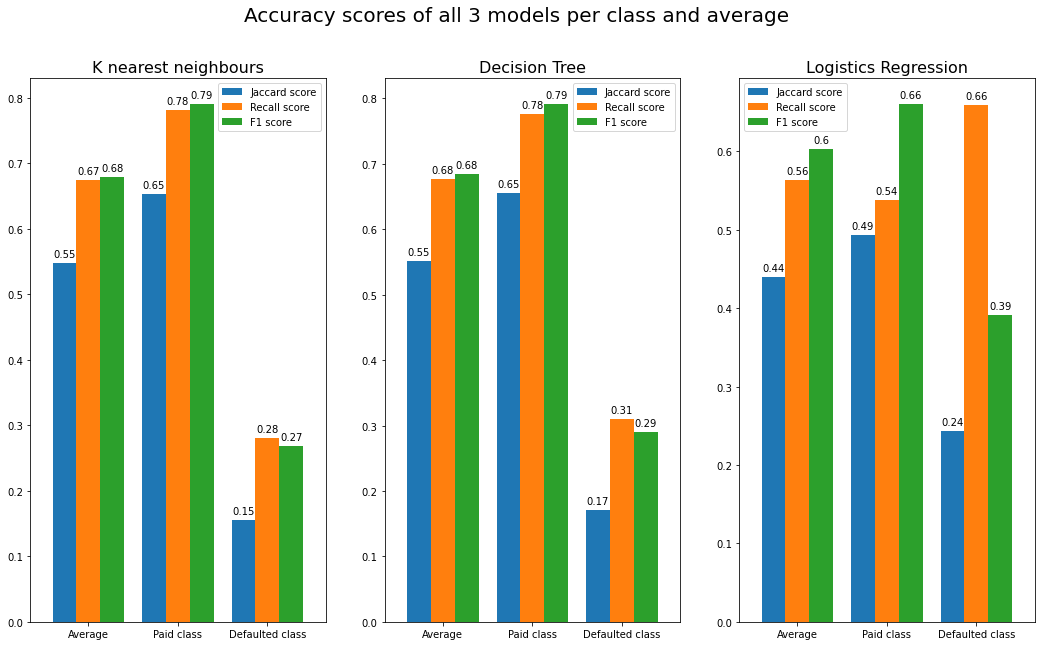

In [128]:
plot_results(results_df)

In [129]:
print(
f'K nearest Neighbours: \n {class_report_KNN_new} \n Decision Tree: \n{class_report_TREE_new} \n Logistic Regression: \n{class_report_LR_new}')

K nearest Neighbours: 
               precision    recall  f1-score   support

           0       0.80      0.78      0.79     11807
           1       0.26      0.28      0.27      3193

    accuracy                           0.67     15000
   macro avg       0.53      0.53      0.53     15000
weighted avg       0.68      0.67      0.68     15000
 
 Decision Tree: 
              precision    recall  f1-score   support

           0       0.81      0.78      0.79     11807
           1       0.27      0.31      0.29      3193

    accuracy                           0.68     15000
   macro avg       0.54      0.54      0.54     15000
weighted avg       0.69      0.68      0.68     15000
 
 Logistic Regression: 
              precision    recall  f1-score   support

           0       0.85      0.54      0.66     11807
           1       0.28      0.66      0.39      3193

    accuracy                           0.56     15000
   macro avg       0.57      0.60      0.53     15000
weighted

# Findings 2nd run

<br>
SMOTE certainly helped improve the accuracy of the models in predicting the minority class, but it did at the expense of the accuracy in predicting the majority class


The largest gain in predicting the minority class has been on the **Logistic Regression** model, reaching an 0.66 of recall score and an 0.39 f1 score. However, the overall accuracy of the model has fallen to an average jaccard score of 0.44.

The best performing model wiht SMOTE is the **Decision Tree** model, which has improved from a 0 to an 0.31 recall score in predicting the minority class, doing so while retaining a fairly high accuracy in predicting the majority class.

___


### Resampling to an equal distribution

In the next section I will balance out the distribution of the classes to the highest I possibly can by using almost every record of the defaulted class.
 
<br>


In [130]:
# maximum number of the default class is 50611
df_train['LOAN_DEFAULT'].value_counts()

0    182543
1     50611
Name: LOAN_DEFAULT, dtype: int64

In [5]:
# Resampling by taking almost all available record of the default class and an equal number of the paid class
train_paid = df_train.loc[df_train['LOAN_DEFAULT'] == 0].sample(50000)
train_default = df_train.loc[df_train['LOAN_DEFAULT'] == 1].sample(50000)

In [132]:
train_new = pd.concat([train_paid, train_default], axis=0)

In [133]:
from sklearn.utils import shuffle
train_new = shuffle(train_new)

In [134]:
X_train, X_test, y_train, y_test = prepare_data(train_new)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70000, 32) (30000, 32) (70000,) (30000,)


# K nearest neighbors 3rd round

In [146]:
Ks = np.arange(1,20, 1);
scores = []
for k in Ks:
    knn  = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    yhat = knn.predict(X_test)
    scores.append(accuracy_score(y_test, yhat))

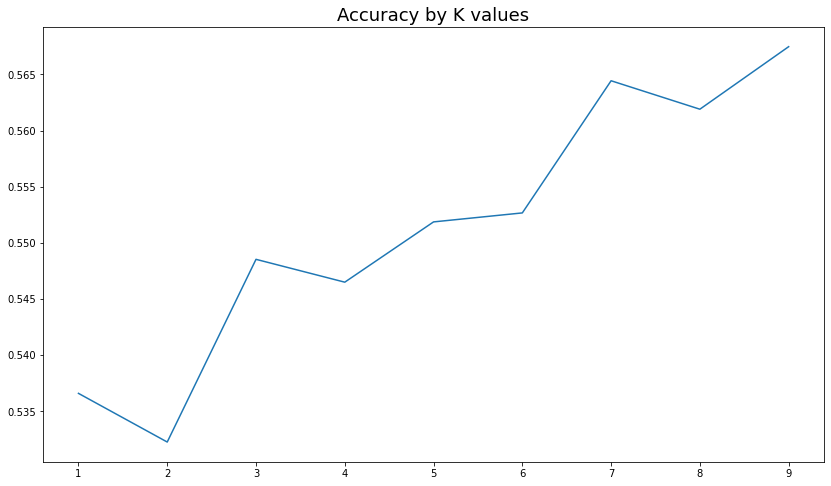

In [147]:
plt.figure(figsize=(14,8))
plt.plot(Ks, scores)
plt.xticks(Ks)
plt.title('Accuracy by K values', size=18)
plt.show()

In [135]:
knn = KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)

In [137]:
KNNpred = knn.predict(X_test)

Normalized confusion matrix
[[0.76772288 0.23227712]
 [0.69994703 0.30005297]]


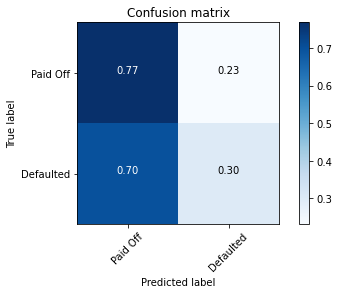

In [138]:
cm = confusion_matrix(y_test, KNNpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= True,  title='Confusion matrix')

# Decision Tree 3rd round

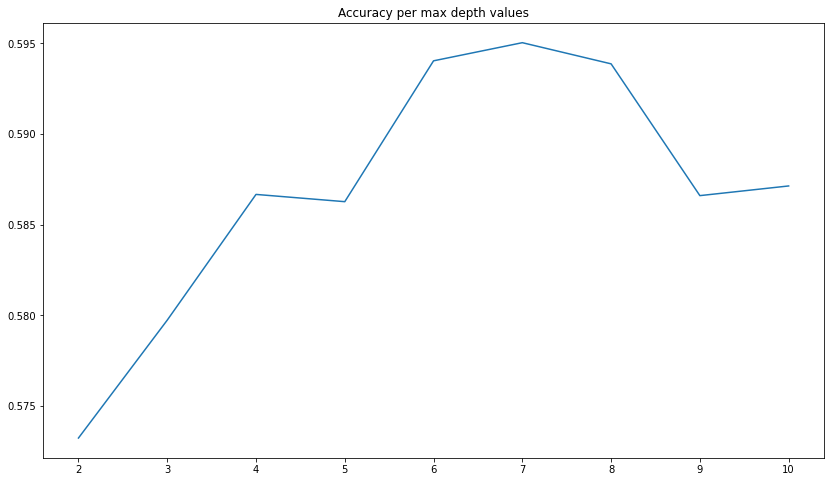

In [139]:
values = range(2,11)
scores = []
for value in values:
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=value).fit(X_train, y_train)
    yhat = tree.predict(X_test)
    scores.append(accuracy_score(y_test, yhat))
plt.figure(figsize=(14,8))
plt.plot(values, scores)
plt.title('Accuracy per max depth values')
plt.show()

In [140]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=7).fit(X_train, y_train)
TREEpred = tree.predict(X_test)

Normalized confusion matrix
[[0.53544576 0.46455424]
 [0.34600106 0.65399894]]


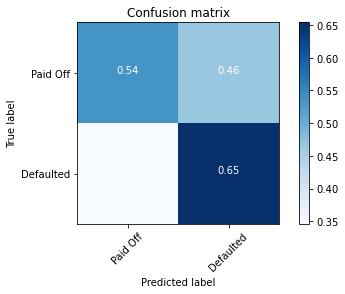

In [141]:
cm = confusion_matrix(y_test, TREEpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= True,  title='Confusion matrix')

# Logistic Regression 3rd round

In [142]:
lr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train.astype('int'))
LRpred = lr.predict(X_test)

Normalized confusion matrix
[[0.56545381 0.43454619]
 [0.36818061 0.63181939]]


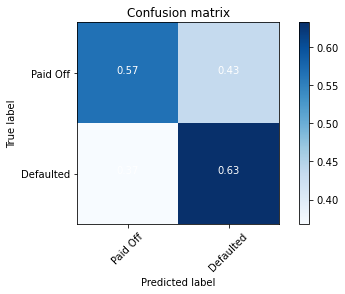

In [143]:
cm = confusion_matrix(y_test, LRpred, labels=[0,1])
plot_confusion_matrix(cm, classes=['Paid Off','Defaulted'],normalize= True,  title='Confusion matrix')

# Results after 3rd run

In [144]:
results_df = results_frame(KNNpred,TREEpred,LRpred)

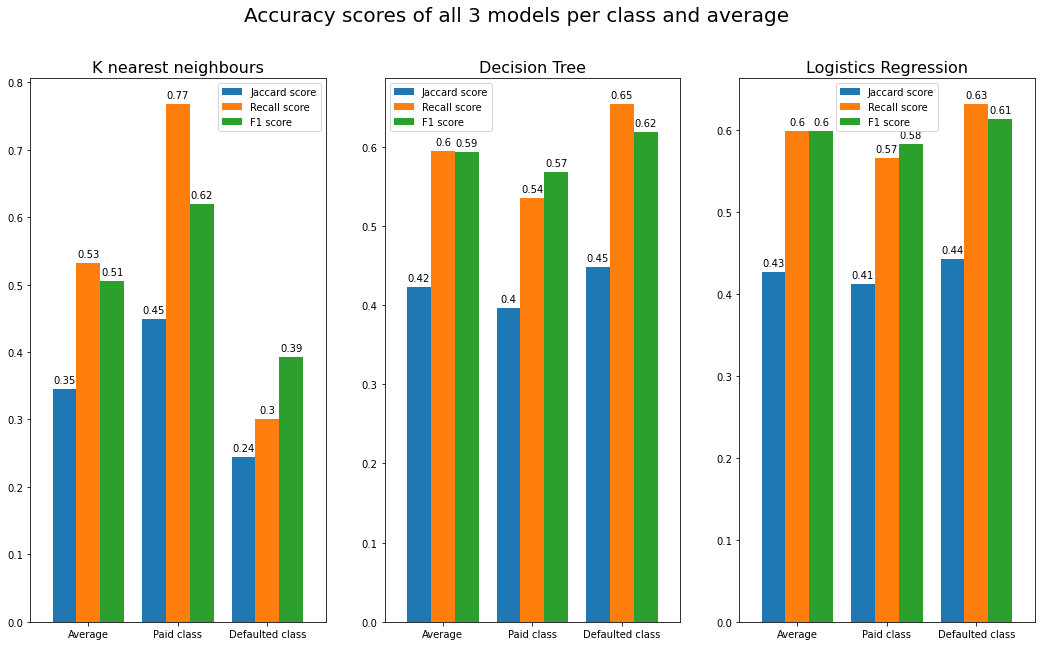

In [145]:
plot_results(results_df)

# Conclusion

<ins>The resampling strategy has not achieved the intended results:<ins>
+ while the accuracy of the default class prediction has improved, the accuracy of predicting the other class has suffered significantly on all three models
+ the K nearest neighbours has gone from a better performing model to the worst performing one with it's overall scores falling to around 0.5 and an 0.35 jaccard score.
+ the other models have also seen their accuracy scores falling both on the average score and on the prediction of the paid class

#### Judging by the above analysis the best choice has been the use of SMOTE on the dataset with the Decision Tree model, along with the K nearest neighbours model.

    
Overall, the prediction of the paid class is significantly more accurate, however, with the low accuracy on predicting the defaulted class the models have very limited potentials in providing accurate predictions.


This can be explained by:
+ inaccuracy/noise in the dataset
+ wrong choices in the featureset
+ choice of models